In [1]:
!pip install pycountry_convert

In [2]:
import os
import random
import numpy  as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import joblib
import math

from pathlib import Path
from torch.optim import AdamW
from torch.utils.data import Sampler, Dataset, DataLoader
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, accuracy_score, average_precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
SEED = 42
random.seed(SEED)        # Python 난수
np.random.seed(SEED)     # NumPy 난수
torch.manual_seed(SEED)  # PyTorch, CPU, GPU 난수

In [4]:
try:
    import pycountry_convert as pc
    _HAS_PCCONVERT = True
except (ModuleNotFoundError, ImportError):
    _HAS_PCCONVERT = False

def _with_pc(name: str) -> str:
    try:
        # 국가명을 ISO-Alpha2로 변환
        # "Korea, Republic of" -> "KR"
        alpha2 = pc.country_name_to_country_alpha2(name)
        # ISO-Alpha2를 대륙 코드로 변환
        # "KR" -> "AS"
        code   = pc.country_alpha2_to_continent_code(alpha2)
        # 대륙 코드를 대륙명으로 변환
        # "AS" -> "Asia"
        return pc.convert_continent_code_to_continent_name(code)
    except Exception:
        return "Other"

def _fallback(name: str) -> str:
    return "Other"

def country_to_continent(country_name: str) -> str:
    if _HAS_PCCONVERT:
        return _with_pc(country_name)
    else:
        return _fallback(country_name)

In [5]:
def build_preprocessor(df_train: pd.DataFrame) -> Pipeline:
    # 특성 분류
    num_cols = [c for c in df_train.columns if df_train[c].dtype != "object"]
    cat_cols = [c for c in df_train.columns if df_train[c].dtype == "object"]

    # 전처리 파이프라인
    pre = ColumnTransformer([
        ("num", MinMaxScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ], remainder="drop")
    return Pipeline([("pre", pre)])

In [6]:
def preprocess_data(df: pd.DataFrame, df_name: str = "Dataset", show_sample: bool = False, pipe: Pipeline | None = None) -> tuple[np.ndarray, np.ndarray, Pipeline]:
    drop_cols = ["url", "content", "ip_add", "ip_addr"]
    cols_to_drop = []                   # 삭제 후보 리스트 생성
    for col in drop_cols:               # 삭제 후보에 해당하는 열 조회
      if col in df.columns:             # DataFrame에 해당하는 열 존재
        cols_to_drop.append(col)        # 삭제 후보 리스트 추가
    df = df.drop(columns=cols_to_drop)  # 열 삭제

    # tld
    if "tld" in df.columns:
        # .str.lower(): 대소문자 통합
        # .astype(int): True/False → 1/0
        df["tld_com"] = (df["tld"].str.lower() == "com").astype(int)
        # 원본 열 제거
        df = df.drop(columns="tld")

    # https
    if "https" in df.columns:
        # .astype(int): True/False → 1/0
        df["https_flag"] = df["https"].astype(str).str.lower().isin(["yes", "true", "1"]).astype(int)
        # 원본 열 제거
        df = df.drop(columns="https")

    # who_is
    if "who_is" in df.columns:
        # .astype(int): True/False → 1/0
        df["whois_flag"] = (df["who_is"].str.lower() == "complete").astype(int)
        # 원본 열 제거
        df = df.drop(columns="who_is")

    # geo_loc
    if "geo_loc" in df.columns:
        # 국가명을 대륙명으로 변환하여 continent 열에 저장
        df["continent"] = df["geo_loc"].apply(lambda x: country_to_continent(str(x)))
        # 원본 열 삭제
        df = df.drop(columns="geo_loc")

    label_map = {"good": 0.0, "bad": 1.0}
    # label 있는 경우
    if "label" in df.columns:
        y_series = (
            df.pop("label")             # label 열에서 데이터 추출 후 DataFrame 에서 제거
              .str.strip().str.lower()  # 공백과 대소문자 처리
              .map(label_map)           # 문자 → 숫자
        )

        # 변환되지 않은 값이 있는 경우
        # .isna().any(): 변환된 값이 NaN이면 True 반환
        if y_series.isna().any():
            unknown = df.loc[y_series.isna(), "label"].unique()
            raise ValueError(f"Unknown label is detected.: {unknown}")

        y = y_series.astype(float).values  # 1-D (n, )

    # label 없는 경우
    else:
        y, y_series = None, None

    # 전처리 파이프라인 적용
    if pipe is None:
        # 파이프라인 빌드 후 전처리
        # Train
        pipe = build_preprocessor(df)
        X = pipe.fit_transform(df)
    else:
        # 기존 파이프라인을 이용하여 전처리
        # Validation, Test
        X = pipe.transform(df)

    # 시각화: Preprocessed Sample
    if show_sample:
        feature_names = pipe.named_steps["pre"].get_feature_names_out()
        viz_df = pd.DataFrame(X[:10], columns=feature_names)
        if y is not None:
            viz_df["label"] = y_series.values[:10]
        cell_text = viz_df.values.round(3).tolist()
        col_labels = viz_df.columns.tolist()
        fig, ax = plt.subplots(figsize=(len(col_labels)*1.2, 5))
        ax.axis("off")
        ax.set_title(f"Preprocessed Sample: {df_name}", fontweight="bold", pad=5)
        table = ax.table(cellText=cell_text, colLabels=col_labels, loc="upper center", cellLoc="left", colLoc="left")
        table.auto_set_font_size(False)
        table.set_fontsize(10);  table.scale(1, 1.2)
        table.auto_set_column_width(col=list(range(len(col_labels))))
        plt.tight_layout();  plt.show()

    # label을 제외한 모든 데이터의 자료형을 PyTorch 기본 dtype인 float32로 캐스팅
    return X.astype(np.float32), y, pipe  # 2-D (n, d)

In [7]:
# model: PyTorch Neural Network
# loader: 배치 단위로 (X, y) 입력
# criterion: 손실 함수
# optimizer: 가중치 업데이트
# device: "cuda" 또는 "cpu"
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()          # Batch 통계, Dropout 활성화

    loss_sum = 0           # 손실 총합
    correct = 0            # 예측과 정답이 같은 데이터 개수
    total = 0              # 처리한 데이터 개수

    y_true_collect = []    # 참값
    y_logits_collect = []  # 예측값

    # DataLoader가 미니 배치 (X, y)를 입력으로 제공
    for X, y in loader:
        # .unsqueeze(1): (batch,) → (batch, 1)
        X, y = X.to(device), y.to(device).unsqueeze(1)
        y_logits = model(X)            # 예측 확률 (batch, 1)
        loss = criterion(y_logits, y)  # 손실 함수 계산

        optimizer.zero_grad()          # 이전 배치의 기울기 초기화
        loss.backward()                # 역전파를 통해 기울기 계산
        optimizer.step()               # 가중치 업데이트

        loss_sum += loss.item() * len(X)                    # 평균 손실 * 배치 크기
        total    += len(X)

        y_true_collect.append(y.detach().cpu())             # 참값
        y_logits_collect.append(y_logits.detach().cpu())    # 예측값

    y_true   = torch.cat(y_true_collect).numpy().ravel()    # 참값
    y_logits = torch.cat(y_logits_collect).numpy().ravel()  # 예측값

    return {
        "loss": loss_sum / total,
        "ap"  : average_precision_score(y_true, y_logits),
    }

In [8]:
# eval_epoch() 객체에 torch.set_grad_enabled(False) 설정
@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()

    loss_sum = correct = total = 0

    y_true_collect = []
    y_logits_collect = []

    for X, y in loader:
        X, y = X.to(device), y.to(device).unsqueeze(1)
        y_logits = model(X)
        loss = criterion(y_logits, y)

        loss_sum += loss.item() * len(X)
        total    += len(X)

        y_true_collect.append(y.cpu())
        y_logits_collect.append(y_logits.cpu())

    y_true   = torch.cat(y_true_collect).numpy().ravel()
    y_logits = torch.cat(y_logits_collect).numpy().ravel()

    return {
        "loss": loss_sum / total,
        "ap"  : average_precision_score(y_true, y_logits),
    }

In [9]:
@torch.no_grad()
def find_best_threshold(model, val_loader, device):
    model.eval()

    y_probs = []
    y_trues = []

    for X, y in val_loader:
        X = X.to(device)
        logits = model(X).cpu().squeeze().numpy()
        p = 1 / (1 + np.exp(-logits))
        y_probs.extend(p)
        y_trues.extend(y.numpy().ravel())
    y_probs = np.array(y_probs)
    y_trues = np.array(y_trues)

    # prec: 임계값 별 Precision(정밀도) --> '양성'으로 예측한 것 중 실제로 '양성'인 비율
    # rec:  임계값 별 Recall(재현율)    --> 전체 '양성' 중에서 모델이 찾은 '양성' 비율
    # ths:  임계값 후보
    prec, rec, ths = precision_recall_curve(y_trues, y_probs)
    # F-Score 계산
    f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
    # ths 배열이 f1_scores보다 짧으므로 f1_scores[:-1]으로 계산
    # np.nanargmax(): NaN을 무시하고 최대값을 도출할 수 있는 인덱스를 찾아서 반환
    best_idx  = np.nanargmax(f1_scores[:-1])
    # F-Score가 가장 높은 임계값 반환
    best_thr  = ths[best_idx]

    return best_thr

In [10]:
@torch.no_grad()
def test(model, data_loader, criterion, device, threshold):
    model.eval()

    loss_sum, total = 0.0, 0
    probs, trues = [], []

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device).unsqueeze(1)

        logits = model(X)
        loss   = criterion(logits, y)

        loss_sum += loss.item() * X.size(0)
        total    += X.size(0)

        p = torch.sigmoid(logits).cpu().numpy().ravel()
        probs.extend(p)
        trues.extend(y.cpu().numpy().ravel())

    probs = np.array(probs)
    trues = np.array(trues)
    preds = (probs >= threshold).astype(int)

    return {
        "loss": loss_sum / total,
        "ap"  : average_precision_score(trues, probs),
        "acc" : accuracy_score(trues, preds),
        "f1"  : f1_score(trues, preds),
    }

In [11]:
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y): self.X = torch.from_numpy(X); self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i].float(), self.y[i].float()

In [12]:
class MLP(nn.Module):
    # in_dim: 입력 벡터 차원
    # p_drop: Dropout 확률
    def __init__(self, in_dim: int, p_drop: float = 0.5):
        # 부모 클래스 초기화
        super().__init__()
        # nn.BatchNorm1d(): 배치 정규화
        # 학습 모드: 현재 배치 통계 사용 -> 가변
        # 평가 모드: 누적 배치 통계 사용 -> 고정
        # nn.Dropout(): 뉴런 비활성
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p_drop),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p_drop),

            nn.Linear(32, 64),
            nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p_drop),

            nn.Linear(64, 1)
        )

    # 순전파 정의
    # 입력 x(배치, in_dim)를 self.net Sequential에 통과시킨 출력 확률 (배치, 1) 반환
    def forward(self, x):
        return self.net(x)

In [13]:
class BalancedBatchSampler(Sampler):
    # batch_size의 절반을 benign(0)에서, 나머지 절반을 malicious(1)에서 뽑아 전달
    def __init__(self, labels: torch.Tensor, batch_size: int, drop_last: bool = True):
        assert batch_size % 2 == 0
        self.batch_size = batch_size       # 배치 크기는 짝수
        self.half       = batch_size // 2  # 배치당 각 클래스에서 뽑을 개수
        self.drop_last  = drop_last        # 남는 샘플은 Drop

        # 라벨에서 인덱스 추출
        self.pos_idx = torch.where(labels == 1)[0]
        self.neg_idx = torch.where(labels == 0)[0]

        # 무작위 순서로 섞인 인덱스 배열 초기화
        self.pos_idx_shuffled = None
        self.neg_idx_shuffled = None
        self._shuffle()

        # epoch당 만들 수 있는 배치 개수 계산
        self.num_batches = min(len(self.pos_idx), len(self.neg_idx)) // self.half

    # 각 클래스별 인덱스 셔플
    # epoch당 배치 순서 차별화
    def _shuffle(self):
        self.pos_idx_shuffled = self.pos_idx[torch.randperm(len(self.pos_idx))]
        self.neg_idx_shuffled = self.neg_idx[torch.randperm(len(self.neg_idx))]

    def __iter__(self):
        self._shuffle()  # epoch 마다 셔플
        for i in range(self.num_batches):
            pos_slice = slice(i * self.half, (i + 1) * self.half)
            neg_slice = slice(i * self.half, (i + 1) * self.half)
            batch_idx = torch.cat([self.pos_idx_shuffled[pos_slice], self.neg_idx_shuffled[neg_slice]])
            yield batch_idx[torch.randperm(len(batch_idx))]  # 배치 내부 셔플
        if not self.drop_last:
            # 남은 인덱스를 합쳐 마지막 배치 반환
            leftover = torch.cat([
                self.pos_idx_shuffled[self.num_batches * self.half:],
                self.neg_idx_shuffled[self.num_batches * self.half:]
            ])
            if len(leftover):
                yield leftover

    def __len__(self):
        # drop_last=True:  완전한 배치 개수 반환
        # drop_last=False: 마지막 배치까지 포함한 배치 개수 반환
        return self.num_batches if self.drop_last else \
               (self.num_batches + 1 if len(self) else 0)

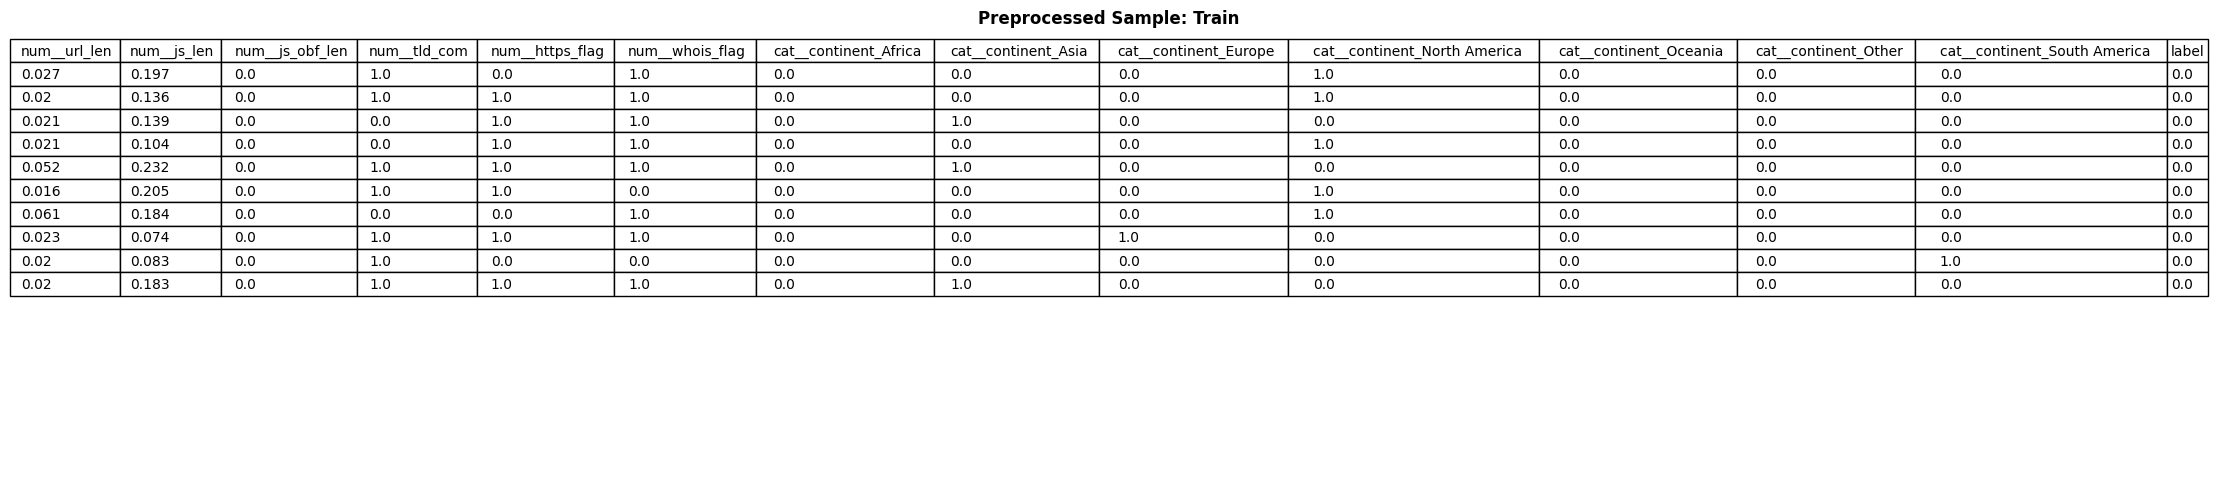

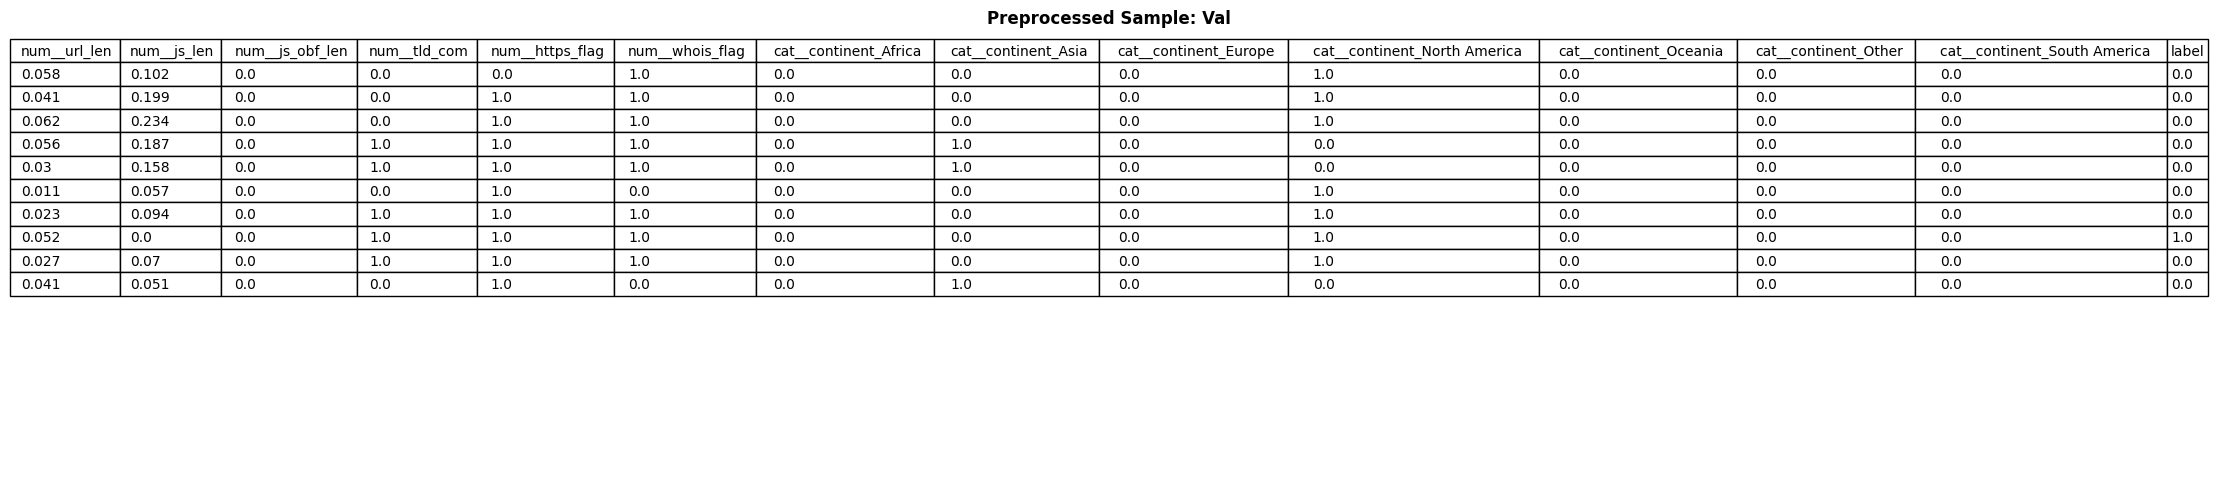

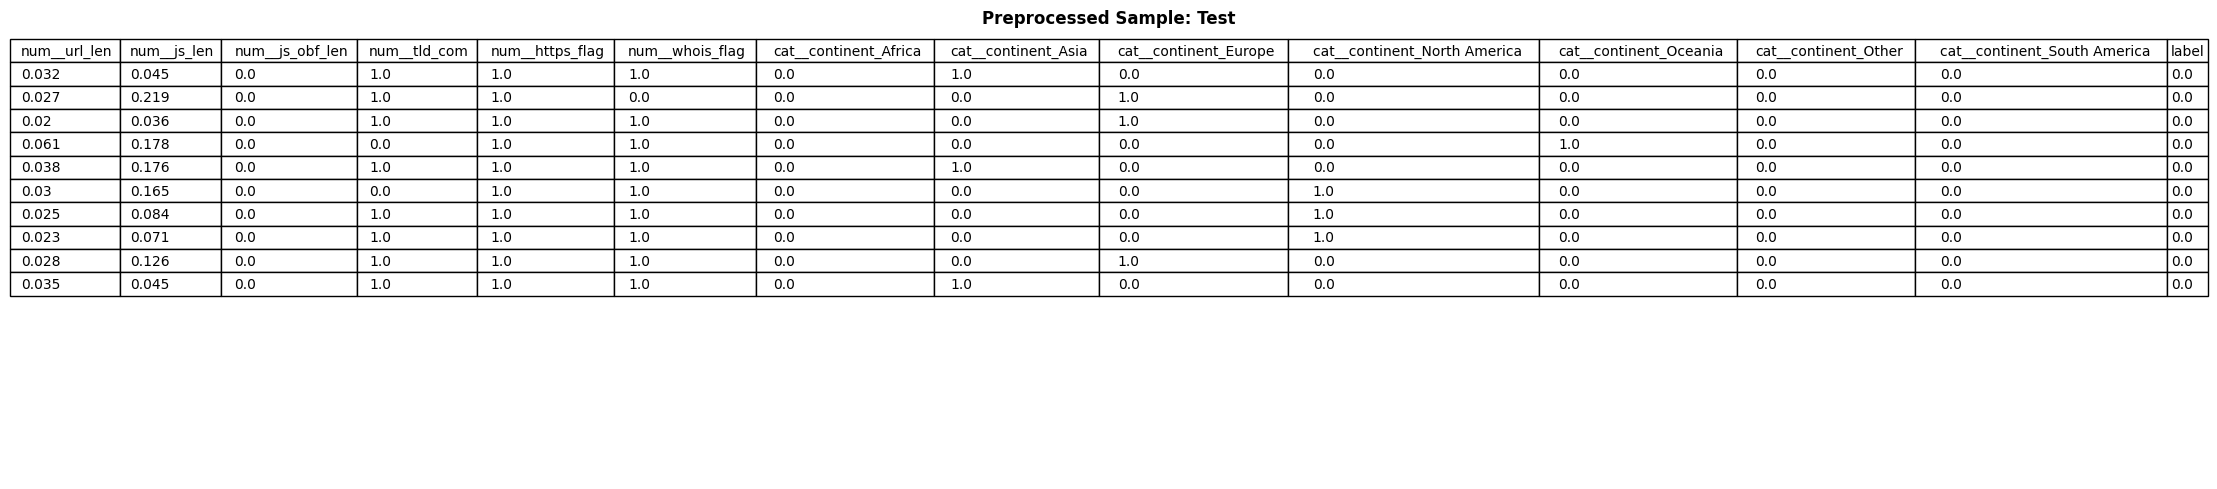

In [14]:
if __name__ == "__main__":
    # 경로 지정
    DIRECTORY = Path("/content/drive/MyDrive/Colab Notebooks")
    train_csv = DIRECTORY / "train.csv"
    test_csv  = DIRECTORY / "test.csv"

    # CSV 파일 존재 여부 확인
    if not (train_csv.exists() and test_csv.exists()):
        raise FileNotFoundError("CSV file is not exist.")

    raw_train_df = pd.read_csv(train_csv)
    raw_test_df  = pd.read_csv(test_csv)

    data = []
    for name, df in [("Train", raw_train_df), ("Test", raw_test_df)]:  # 튜플 순회
        vc = df["label"].str.strip().str.lower().value_counts()        # 열에서 공백 제거 및 소문자 변환 후 개수를 세어 Series로 반환
        n_good = int(vc.get("good", 0))                                # Benign URL 개수
        n_bad  = int(vc.get("bad",  0))                                # Malicious URL 개수
        data.append((name, n_good, n_bad))                             # 데이터 추가

    # 리스트 분리
    datasets         = [d[0] for d in data]                            # ["Train", "Test"]
    benign_counts    = [d[1] for d in data]                            # [n_good_train, n_good_test]
    malicious_counts = [d[2] for d in data]                            # [n_bad_train , n_bad_test]

    # test_size=0.15: 학습 데이터 중에서 15%를 검증 데이터로 할당
    # stratify=raw_train_df["label"]: 데이터 불균형 방지
    # random_state=SEED: 모델을 다시 학습해도 동일한 재현성 확보
    train_df, val_df = train_test_split(raw_train_df, test_size=0.15, stratify=raw_train_df["label"], random_state=SEED)

    # 데이터 전처리
    X_train, y_train, pipe = preprocess_data(train_df,    "Train", show_sample=True, pipe=None)
    X_val,   y_val,   _    = preprocess_data(val_df,      "Val",   show_sample=True, pipe=pipe)
    X_test,  y_test,  _    = preprocess_data(raw_test_df, "Test",  show_sample=True, pipe=pipe)

    # 파이프라인 저장
    joblib.dump(pipe, "preprocess.joblib")

    # 미니 배치
    BATCH = 256

    # 불균형 방지: 데이터 샘플링
    labels_t   = torch.tensor(y_train)
    batch_sampler = BalancedBatchSampler(labels_t, BATCH)

    train_loader = DataLoader(NumpyDataset(X_train, y_train), batch_sampler=batch_sampler)
    val_loader   = DataLoader(NumpyDataset(X_val,   y_val),   batch_size=BATCH, shuffle=False)
    test_loader  = DataLoader(NumpyDataset(X_test,  y_test),  batch_size=BATCH, shuffle=False)

    INPUT_DIM = train_loader.dataset.X.shape[1]                                   # Feature 개수
    device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")      # Device 설정
    model     = MLP(INPUT_DIM).to(device)                                         # Model 초기화

    # 불균형 방지: 손실 함수
    _, n_good_train, n_bad_train = next(x for x in data if x[0] == "Train")
    ratio = n_good_train / n_bad_train
    pos_weight = torch.tensor([math.log1p(ratio)], dtype=torch.float32, device=device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)                                  # 손실 함수: Binary Cross Entropy With Logits Loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5, eps=1e-8)  # 학습률: 1e-3, L2 정규화 계수: 1e-5

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",                    # 손실 감소를 기준으로 설정
    factor=0.5,                    # 개선 없을 때 학습률 반감
    patience=1                     # 3번 연속 개선 없으면 학습률 조정
    )

    EARLY_PATIENCE = 3             # Early-Stopping이 발생하기 위한 조건
    best_val_loss  = float("inf")  # 초기 검증 손실을 무한대로 초기화 후 관측된 최소값
    trigger        = 0             # 검증 손실이 개선되지 않은 횟수
    NUM_EPOCH      = 50            # 학습 횟수

    history = {"train_loss": [], "val_loss": [], "train_ap": [], "val_ap": []}
    results_list = []

    # 학습 모드
    for epoch in range(1, NUM_EPOCH + 1):
        tr = train_epoch(model, train_loader, criterion, optimizer, device)
        va = eval_epoch (model, val_loader, criterion, device)

        # 학습 지표 수집
        results_list.append({
            "Epoch":             epoch,
            "Train Loss (%)":    f"{tr['loss'] * 100:.2f}",
            "Train PR-AUC (%)":  f"{tr['ap']   * 100:.2f}",
            "Val Loss (%)":      f"{va['loss'] * 100:.2f}",
            "Val PR-AUC (%)":    f"{va['ap']   * 100:.2f}",
        })

        # 그래프 데이터 수집
        for m in ("loss", "ap"):
            history[f"train_{m}"].append(tr[m])
            history[f"val_{m}"].append(va[m])

        # 스케줄러
        scheduler.step(va["loss"])

        # 새로 측정한 검증 손실이 기존 최소값보다 낮으면 성능 개선
        if va['loss'] < best_val_loss:
            best_val_loss = va['loss']                       # 최소값 업데이트
            trigger = 0                                      # Early-Stopping 조건 초기화
            torch.save(model.state_dict(), "model.pt")       # 최적 가중치 저장
        else:
            trigger += 1
            # 검증 손실이 기존 최소값보다 높거나 같은 경우가 연속적으로 발생하면 "과적합"으로 간주
            if trigger >= EARLY_PATIENCE:
                break

    # 학습 지표 변환
    results_df = pd.DataFrame(results_list)

    # history["val_loss"]: 학습 루프 동안 기록된 Validation Loss 리스트
    # len(history["val_loss"]): 리스트의 길이 반환
    # range(1, N+1): 1부터 N까지 이터러블 생성
    epochs = range(1, len(history["val_loss"]) + 1)

    # torch.load("model.pt"): 최적 가중치 복원
    # model.load_state_dict(): 해당 레이어에 해당 가중치 입력
    model.load_state_dict(torch.load("model.pt"))

    # 최적 임계값 계산
    best_threshold = find_best_threshold(model, val_loader, device)

    # 평가 모드
    te = test(model, test_loader, criterion, device, best_threshold)

    # 평가 지표 수집
    results_test = pd.DataFrame([{
        "Test Loss (%)":     f"{te['loss'] * 100:.2f}",
        "Test PR-AUC (%)":   f"{te['ap']  * 100:.2f}",
        "Test Accuracy (%)": f"{te['acc']  * 100:.2f}",
        "Test F-Score (%)":  f"{te['f1']   * 100:.2f}",
    }])

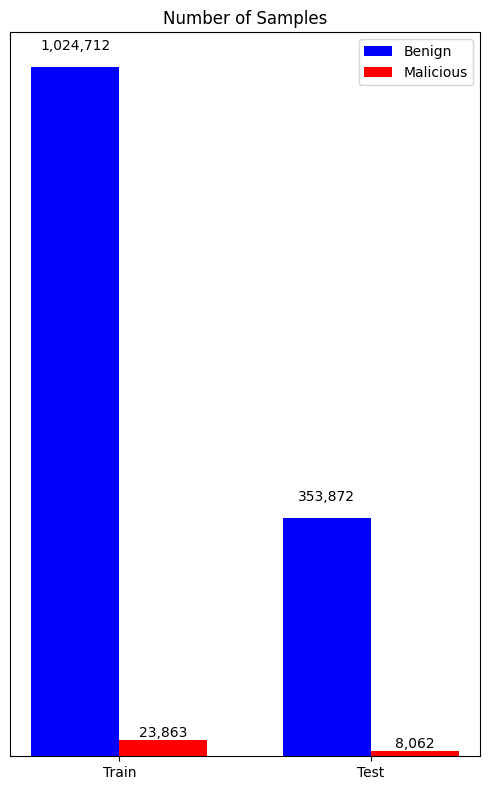

In [15]:
    # 시각화: Number of Samples
    x      = np.arange(len(datasets))
    width  = 0.35
    fig, ax = plt.subplots(figsize=(5, 8))
    ax.bar(x - width/2, benign_counts,    width, label="Benign",    color="blue")
    ax.bar(x + width/2, malicious_counts, width, label="Malicious", color="red")
    for i, (b, m) in enumerate(zip(benign_counts, malicious_counts)):
        ax.text(x[i] - width/2, b + max(benign_counts)*0.02, f"{b:,}", ha="center", va="bottom")
        ax.text(x[i] + width/2, m + max(malicious_counts)*0.02, f"{m:,}", ha="center", va="bottom")
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_yticks([])
    ax.set_title("Number of Samples")
    ax.legend()
    plt.tight_layout()
    plt.show()

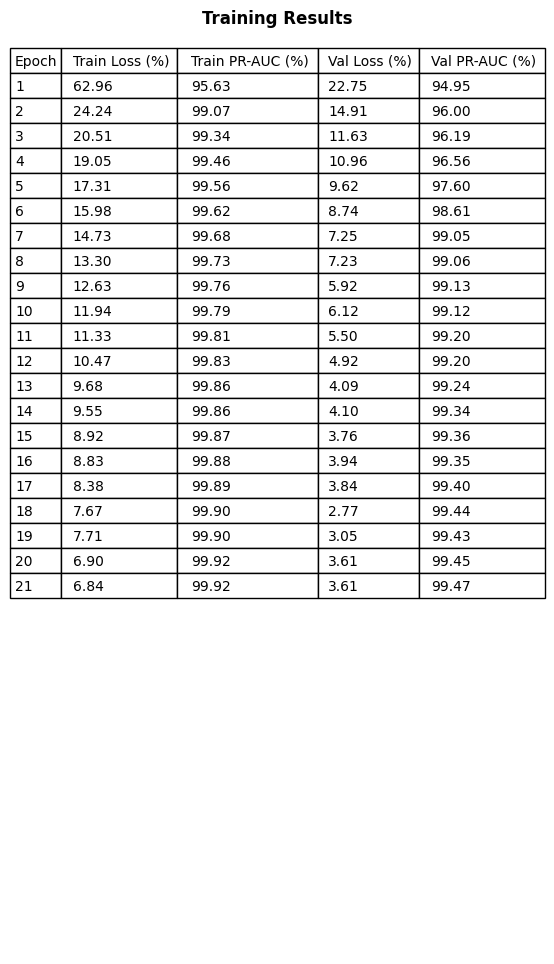

In [16]:
    # 시각화: Training Results
    fig, ax = plt.subplots(figsize=(len(results_df.columns)*1.2, 0.5 * len(results_df) + 1.5))
    ax.axis("off")
    ax.set_title("Training Results", fontweight="bold", loc="center", pad=5)
    table = ax.table(
        cellText=results_df.values,
        colLabels=results_df.columns,
        loc="upper center",
        cellLoc="left",
        colLoc="left",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(results_df.columns))))
    table.scale(1, 1.5)

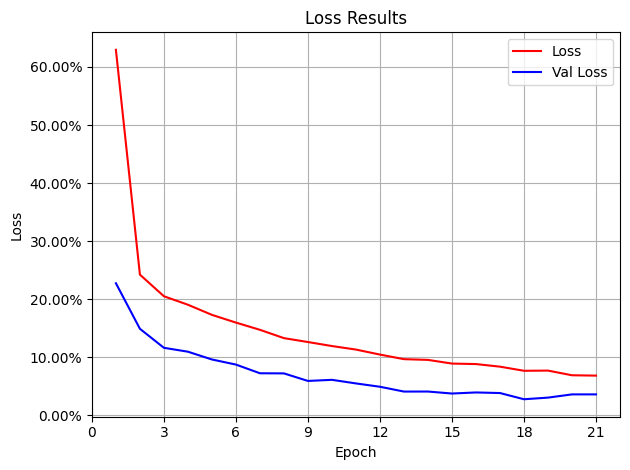

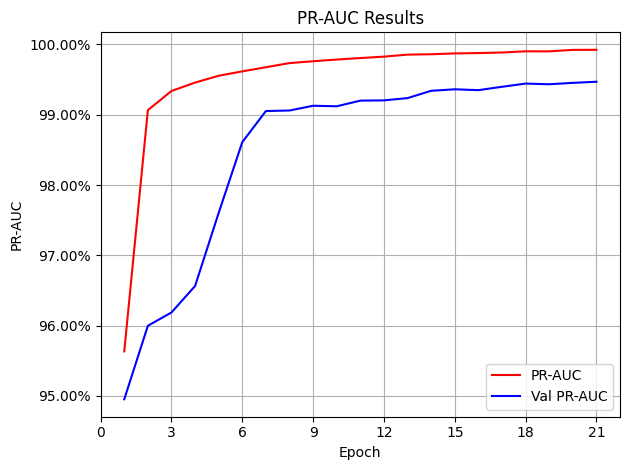

In [17]:
    # 시각화: Loss Results
    plt.figure()
    plt.plot(epochs, history["train_loss"], color="red",  label="Loss")
    plt.plot(epochs, history["val_loss"],   color="blue", label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Results")
    plt.legend(); plt.grid(True);
    ax = plt.gca()
    ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=2))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.tight_layout(); plt.show()

    # 시각화: PR-AUC Results
    plt.figure()
    plt.plot(epochs, history["train_ap"], color="red",  label="PR-AUC")
    plt.plot(epochs, history["val_ap"],   color="blue", label="Val PR-AUC")
    plt.xlabel("Epoch"); plt.ylabel("PR-AUC"); plt.title("PR-AUC Results")
    plt.legend(); plt.grid(True);
    ax = plt.gca()
    ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=2))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.tight_layout(); plt.show()

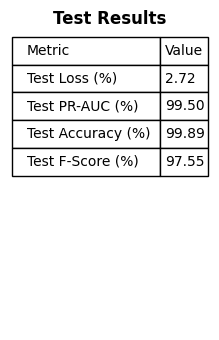

In [18]:
    # 시각화: Test Results
    df_test_t = results_test.T.reset_index()
    df_test_t.columns = ["Metric", "Value"]
    fig, ax = plt.subplots(figsize=(len(df_test_t.columns) * 1.2, len(df_test_t) * 0.5 + 1.5))
    ax.axis("off")
    ax.set_title("Test Results", fontweight="bold", loc="center", pad=5)
    tbl = ax.table(
        cellText=df_test_t.values,
        colLabels=df_test_t.columns,
        loc="upper center",
        cellLoc="left",
        colLoc="left",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.auto_set_column_width(col=list(range(len(df_test_t.columns))))
    tbl.scale(1, 1.5)
    plt.tight_layout()
    plt.show()